# Sales Analysis Using SQL

Addison 2022-08-16

## Introduction

Based on a digital music shop's database containing information about the artists, songs, employees, customers, and customers' purchases, this projects aims to help this business answer the following questions:
- which genres sell the most tracks in the USA?
- what is the total dollar amount of sales assigned to each sales support agent?
- for each country: what is the total number of customers, total value of sales, average value of sales per customer, and average order value?
- do customers prefer purchasing whole albums or individual tracks?

The dataset could be obtained through this link: https://drive.google.com/file/d/1RvSzZgo_oAxHuvtpka5RcBoRjzx49rRP/view?usp=sharing

In [1]:
%%capture
%load_ext sql
%sql sqlite:////Users/apple/chinook.db

To start with, let's have a quick look at the components of the database.

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table");

 * sqlite:////Users/apple/chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


The image below is the database schema.
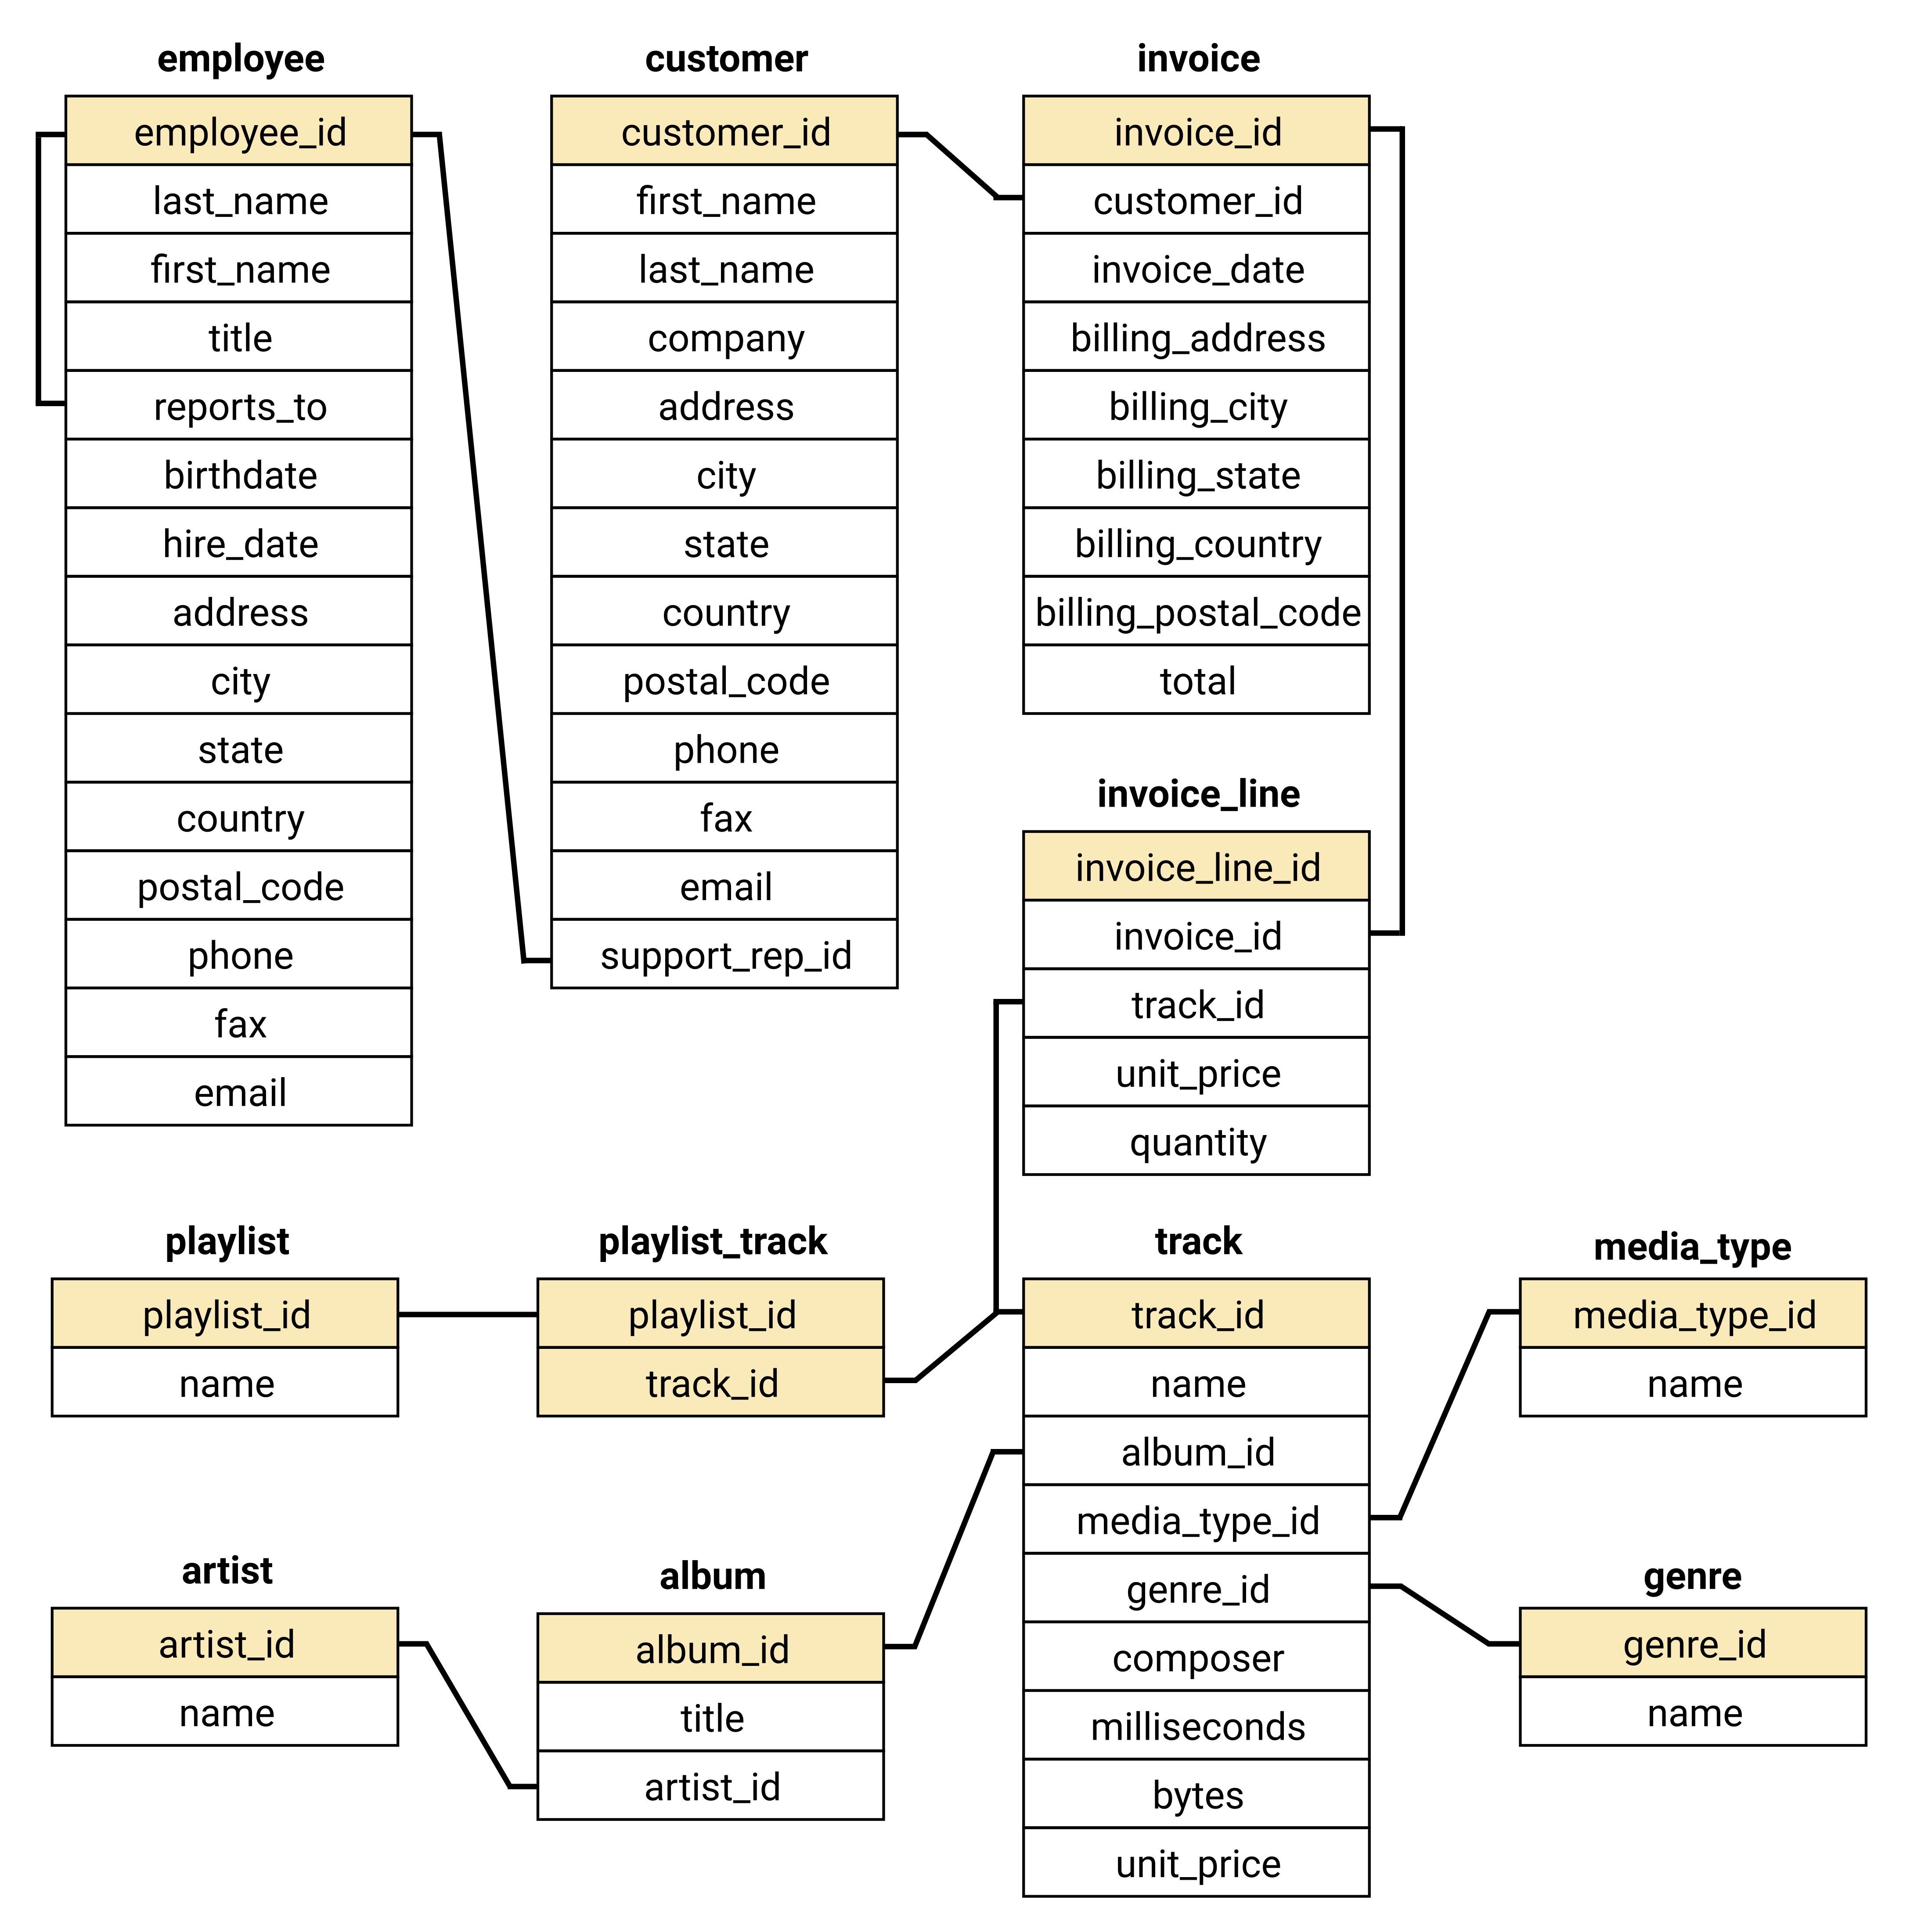

## Which genres sell the most tracks in the USA?

To get the answer to question 1, please refer to the table below.

In the table, **name** is the album genre; **num_track_sold** is the total number of sold tracks per genre; **percentage_track_sold** is calculated by having **num_track_sold** per genre divided by the total number of sold tracks.

In [3]:
%%sql
WITH total_track_sold AS
(SELECT SUM(il.quantity) as sum_sold
 FROM invoice_line il
 INNER JOIN invoice i ON i.invoice_id = il.invoice_id
 WHERE i.billing_country = "USA"
)

SELECT g.name, SUM(il.quantity) 
as num_track_sold, ROUND(CAST(SUM(il.quantity) as Float)/(SELECT 
sum_sold FROM total_track_sold),2) as percentage_track_sold
FROM invoice_line il
LEFT JOIN track t ON t.track_id = il.track_id
LEFT JOIN genre g ON g.genre_id = t.genre_id
LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
WHERE i.billing_country = "USA"
GROUP BY 1, i.billing_country
ORDER BY 2 DESC;


 * sqlite:////Users/apple/chinook.db
Done.


name,num_track_sold,percentage_track_sold
Rock,561,0.53
Alternative & Punk,130,0.12
Metal,124,0.12
R&B/Soul,53,0.05
Blues,36,0.03
Alternative,35,0.03
Latin,22,0.02
Pop,22,0.02
Hip Hop/Rap,20,0.02
Jazz,14,0.01


The table above suggests that the shop should maintain a significantly high stock level of albums in the **Rock** genre since this type of musical albums are best-sellers in the shop, which account for 53% of sold tracks.

## What is the total dollar amount of sales assigned to each sales support agent?

To get the answer to question 2, please refer to the table below.

In [4]:
%%sql
SELECT e.employee_id, e.first_name || " " || e.last_name employee, e.title, ROUND(SUM(i.total),2) as sales
FROM employee e 
LEFT JOIN customer c ON c.support_rep_id = e.employee_id
LEFT JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY e.employee_id
HAVING e.title = "Sales Support Agent";

 * sqlite:////Users/apple/chinook.db
Done.


employee_id,employee,title,sales
3,Jane Peacock,Sales Support Agent,1731.51
4,Margaret Park,Sales Support Agent,1584.0
5,Steve Johnson,Sales Support Agent,1393.92


The table above shows that employee **Jane Peacock** made the highest amount of sales, followed by **Margaret Park** and **Steve Johnson**.

## For each country: what is the total number of customers, total value of sales, average value of sales per customer, and average order value?

To get the answer to question 3, please refer to the table below.

In [5]:
%%sql
WITH n_customer AS

(SELECT country, COUNT(customer_id) 
as num_customer FROM customer
GROUP BY 1
ORDER BY 2),

sales_info AS
(SELECT c.country, SUM(i.total) as total_sales, 
COUNT(i.invoice_id) as num_order
FROM invoice i
INNER JOIN customer c
ON c.customer_id = i.customer_id
GROUP BY c.country)

SELECT n.country, n.num_customer, ROUND(s.total_sales,2) as total_sales, 
ROUND(s.total_sales/n.num_customer,2) as avg_sales_per_cus,
ROUND(s.total_sales/s.num_order,2) as avg_ord_val, " " as group_type
FROM n_customer n INNER JOIN sales_info s
ON n.country = s.country
GROUP BY n.country
HAVING n.num_customer != 1

UNION

SELECT n.country, n.num_customer, ROUND(s.total_sales,2) as total_sales, 
ROUND(s.total_sales/n.num_customer, 2) as avg_sales_per_cus,
ROUND(s.total_sales/s.num_order, 2) as avg_ord_val, "Other" as group_type
FROM n_customer n INNER JOIN sales_info s
ON n.country = s.country
GROUP BY n.country
HAVING n.num_customer = 1
ORDER BY 3 DESC




 * sqlite:////Users/apple/chinook.db
Done.


country,num_customer,total_sales,avg_sales_per_cus,avg_ord_val,group_type
USA,13,1040.49,80.04,7.94,
Canada,8,535.59,66.95,7.05,
Brazil,5,427.68,85.54,7.01,
France,5,389.07,77.81,7.78,
Germany,4,334.62,83.66,8.16,
Czech Republic,2,273.24,136.62,9.11,
United Kingdom,3,245.52,81.84,8.77,
Portugal,2,185.13,92.57,6.38,
India,2,183.15,91.58,8.72,
Ireland,1,114.84,114.84,8.83,Other


In the table above, **num_customer** is the number of customers per country; **total_sales** is the total sales per country; **avg_sales_per_cus** is the average sales per customer calculated by having **total_sales** divided by **avg_sales_per_cus** per country; **avg_ord_val** is the average order value calculated by having **total_sales** divided by the total number of orders per country while **group type** indicates whether a country has a number of customer of 1 (Other) or higher.

The table shows that USA and Canada generate the most sales for the shop.

## Do customers prefer purchasing whole albums or individual tracks?

To get the answer to question 4, please refer to the table below.

In [6]:
%%sql
WITH track_count AS
(SELECT album_id, COUNT(track_id) as num_track
FROM `track`
GROUP BY album_id),

track_merge AS(
SELECT i.invoice_id as invoice_id, i.album_id as album_id, COUNT(track_id) as num_purchased_track, t.num_track
FROM `il_t_join` i
INNER JOIN track_count t
ON t.album_id = i.album_id
GROUP BY i.album_id, i.invoice_id),

purchase_category AS 

(SELECT m.invoice_id as invoice_id, m.album_id, m.num_purchased_track, m.num_track,
CASE
WHEN m.num_purchased_track =  m.num_track THEN 0 ELSE 1
END AS "purchase_type"
FROm track_merge m),

purchase_category_by_invoice AS
(SELECT p.`invoice_id` invoice_id, SUM(p.purchase_type) as purchase_type
FROM purchase_category p
GROUP BY p.invoice_id),

purchase_type_count AS

(SELECT pi.purchase_type AS purchase_type, COUNT(pi.invoice_id) AS num_invoice
FROM purchase_category_by_invoice pi
GROUP BY purchase_type), 

purchase_type_count_merge AS

(SELECT SUM(pt.num_invoice) as num_invoice, 
CASE
WHEN pt.purchase_type = 0 THEN "album" ELSE "individual_tracks"
END AS purchase_category
FROM purchase_type_count pt
GROUP BY purchase_category),

num_total_invoice AS
(SELECT SUM(num_invoice) as total_invoice
FROM purchase_type_count_merge)

SELECT purchase_category, num_invoice, ROUND(num_invoice*1.0/(SELECT total_invoice FROM num_total_invoice),2)
AS percentage_purchase_type
FROM purchase_type_count_merge



 * sqlite:////Users/apple/chinook.db
Done.


purchase_category,num_invoice,percentage_purchase_type
album,114,0.19
individual_tracks,500,0.81


Before discussing the table above, it is worth noting the price of a whole album and that of all individual tracks in that whole album are the same. 

The shop also only allows customers to purchase either whole albums or a collection of one or more individual tracks. In other words, if purchased tracks constitute a complete album or complete albums, the purchase of those tracks belongs to the **album** purchase category. Otherwise, the purchase is considered to be in the **individual_tracks** purchase category.

It is also worth mentioning that **num_invoice** is the total number of invoices per purchase category while **percentage_purchase_type** is calculated by having **num_invoice** divided by the total number of invoices across purchase categories.

Regarding customer purchase preference, from the table above, it is evident that customers prefer buying collections of individual tracks to whole albums. If the company applies a new policy that it only allows whole album purchases, it might face a loss in sales. Thus, it is suggested that the company should maintain its current purchase policy, which also gives customers flexibility in shopping for music products.